1. Read Image
2. Calibrate
3. Change the color space to appropriate
4. Apply color and gradient thresholds
5. Perspective transform
6. Sliding window search for lanes

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# to read images named as name1, name2, ...
import glob
%matplotlib inline
# prepare object points
# The number of inside corners in x and y
nx = 9
ny = 6
# Store Object points and image points from all the images
objPoints = []  # 3D points in real world space
imgPoints = []  # 3D points in image place

# Prepare object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # a list of x, y coordinates
#print(np.mgrid[0:9, 0:6])
#print(np.mgrid[0:9, 0:6].T)    # break down for reference
#print(np.mgrid[0:9, 0:6].T.reshape(-1, 2))    # break down for reference

In [3]:
def corners_unwarp(img, nx, ny, mtx, dist, corners):
    # Pass in your image into this function
    # Write code to do the following steps
    img_size = (img.shape[1], img.shape[0])
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # One especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    # extra space for including more of the image
    xe = (corners[1][0][0] - corners[0][0][0])/2
    ye = (corners[nx][0][1] - corners[0][0][1])/2
    
    src = np.float32((corners[0][0] - [xe, ye],
        corners[nx-1][0] + [xe, -ye],
        corners[(nx*ny)-1][0] + [xe, ye],
        corners[nx*(ny-1)][0] - [xe, -ye]))
    tl, tr, br, bl = src
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[0, 0],
        [img_size[0] - 1, 0],
        [img_size[0] - 1, img_size[1] - 1],
        [0, img_size[1] - 1]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [4]:
# Make a list of calibration images
image_names = glob.glob('./camera_cal/calibration*.jpg')
images = []
rows = len(image_names)
# fig1 = plt.figure(figsize=(9,int(4.5*rows)+1))
cam_mtx = None
cam_dist = None
print('|>', end='')
for img_name in image_names:
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
    # If found, store imagepoint and object point data and draw corners
    if ret == True:
        objPoints.append([np.copy(objp)])
        imgPoints.append([corners])
        # Draw and display the corners
        imc = np.copy(img)
        cv2.drawChessboardCorners(imc, (nx, ny), corners, ret)
        images.append(imc)
        #fig1.add_subplot(rows, 2, len(images)*2 -1)
        #plt.imshow(imc)
        
        # These are the arrays you calculated using cv2.calibrateCamera()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints[-1], imgPoints[-1], gray.shape[::-1], \
                                                           None, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
        cam_mtx = mtx
        cam_dist = dist
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        warped_image = corners_unwarp(undist, nx, ny, mtx, dist, corners)
        #fig1.add_subplot(rows, 2, len(images)*2)
        #plt.imshow(warped_image)
        print('-', end='')
print('<|')
#plt.show()


|>-----------------<|


In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_threshold_canny(original_image, src_image):
    """ Compute the median of the single channel pixel intensities and
        use it to determine low and high thresholds for canny edge detection function.
        Source: https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    """
    m = np.median(original_image)
    sigma=0.33
    # apply automatic Canny edge detection using the computed median
    low_threshold = int(max(0, (1.0 - sigma) * m))
    high_threshold = int(min(255, (1.0 + sigma) * m))
    return canny(src_image, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [5]:
#fig1 = plt.figure(figsize=(16,10))
#fig1.add_subplot(2, 2, 1)
#plt.imshow(t_img)
#fig1.add_subplot(2, 2, 2)
#plt.imshow(img_rgb[:,:,1], cmap="gray")
#fig1.add_subplot(2, 2, 3)
#plt.imshow(img_hls[:,:,2], cmap="gray")
#img_hsv = cv2.cvtColor(t_img, cv2.COLOR_BGR2HSV)
#fig1.add_subplot(2, 2, 4)
#plt.imshow(img_hsv[:,:,2], cmap="gray")
#plt.show()
#print(np.median(img_rgb[:,:, 0]))

#binary = np.zeros_like( img_hls[:,:,1])
#binary[img_hls[:,:,2] >= 150] = 1
#plt.imshow(binary, cmap="gray")
#plt.show()

#binary = np.zeros_like( img_hsv[:,:,1])
#binary[(img_hls[:,:,2] >= 150) & (img_hsv[:,:,2] >= 150)] = 1
#plt.imshow(binary, cmap="gray")
#plt.show()

#binary = np.zeros_like( img_hsv[:,:,1])
#binary[(((img_rgb[:,:,0] >= red_threshold) 
#             | (img_rgb[:,:,1] >= green_threshold)
#             | (img_rgb[:,:,1] >= blue_threshold))
#        | (img_hls[:,:,2] >= 150)) & (img_hsv[:,:,2] >= 150)] = 1
#plt.imshow(binary, cmap="gray")
#plt.show()


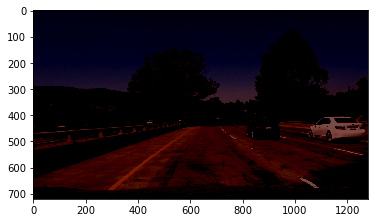

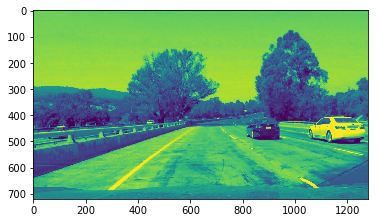

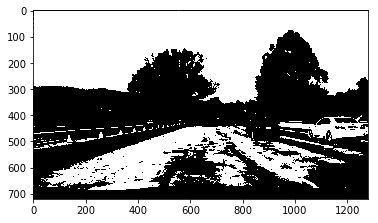

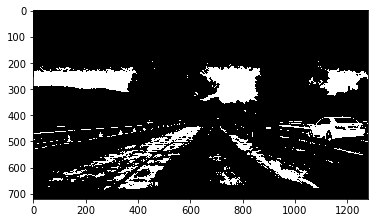

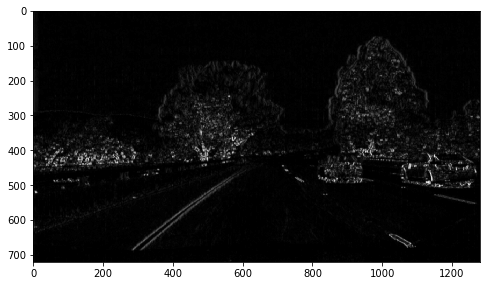

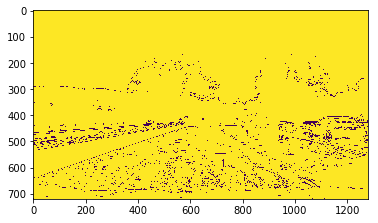

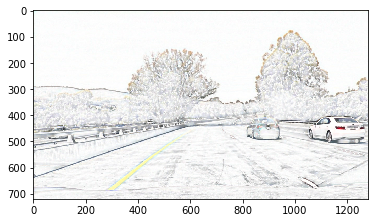

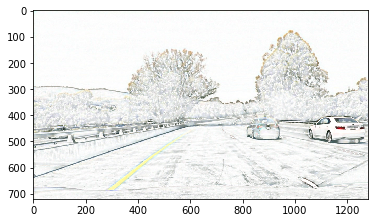

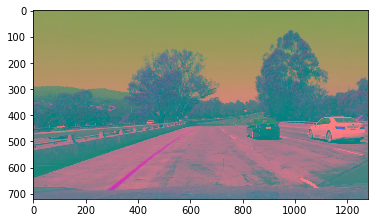

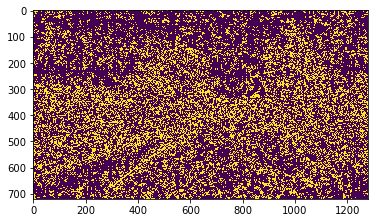

In [29]:
road = 1

t_img = cv2.imread("./test_images/test"+str(road)+".jpg")
img_rgb = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
img_hls = cv2.cvtColor(t_img, cv2.COLOR_BGR2HLS)
img_hsv = cv2.cvtColor(t_img, cv2.COLOR_BGR2HSV)
img_yuv = cv2.cvtColor(t_img, cv2.COLOR_BGR2YUV)


t1 = t_img[:,:,0] - np.median(t_img[:,:, 0])*1.2
t2 = t_img[:,:,1] - np.median(t_img[:,:, 1])*1.2
t3 = t_img[:,:,2] - np.median(t_img[:,:, 2])*1.2
t1[t1<0] = 0
t2[t2<0] = 0
t3[t3<0] = 0
t_img[:,:,0] = t1
t_img[:,:,1] = t2
t_img[:,:,2] = t3
img_rgb2 = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb2)
#plt.imshow(img_rgb2[:,:,0], cmap="gray")
plt.show()


hsv2 = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
plt.imshow(hsv2[:,:,2])
plt.show()
t1 = np.zeros_like(hsv2[:,:,0])
t1[hsv2[:,:,2] > 180] = 1
plt.imshow(t1, cmap="gray")
plt.show()

hls2 = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HLS)
#plt.imshow(hls2)
t2 = np.zeros_like(hls2[:,:,1])
t2[hls2[:,:,1] >180] = 1
plt.imshow(t2, cmap="gray")
plt.show()

gray_ip = hls2[:,:,2]
sobelx = cv2.Sobel(gray_ip, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray_ip, cv2.CV_64F, 0, 1, ksize=5)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
blur_image = gaussian_blur(scaled_sobelx, 5)
cm = (blur_image + t1)//2
plt.figure(figsize=(8,5))
plt.imshow(cm, cmap='gray')
plt.show()

im_at_mean = cv2.adaptiveThreshold(img_rgb2[:,:,0], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 4)
plt.imshow(im_at_mean)
plt.show()

rgb_planes = cv2.split(img_rgb)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = np.zeros_like(diff_img)
    cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.imshow(result)
plt.show()
plt.imshow(result_norm)
plt.show()
plt.imshow(img_yuv)
plt.show()

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_thresh = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobelx)
    binary_output[(sobel_thresh >= thresh[0]) & (sobel_thresh <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
dir_binary = dir_threshold(hsv2[:,:,0], sobel_kernel=7, thresh=(0.7, 1.3))
plt.imshow(dir_binary)
plt.show()

18.861666666666668


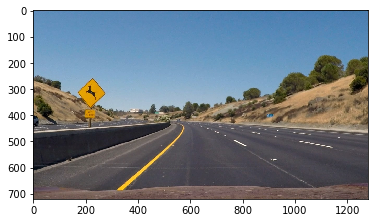

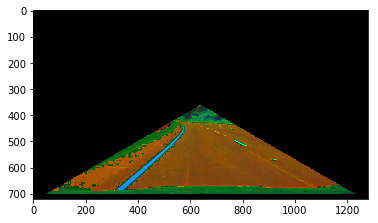

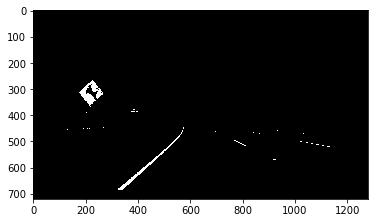

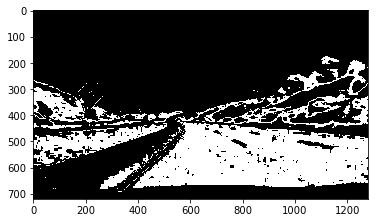

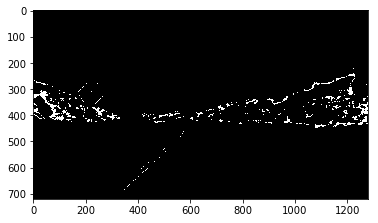

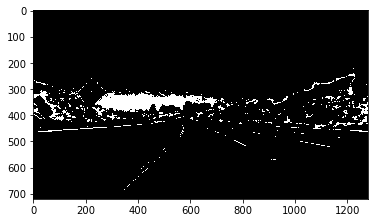

In [93]:
road = 2

t_img = cv2.imread("./test_images/test"+str(road)+".jpg")
t_img = cv2.resize(t_img, (1280, 720))
img_rgb = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
img_hls = cv2.cvtColor(t_img, cv2.COLOR_BGR2HLS)
img_hsv = cv2.cvtColor(t_img, cv2.COLOR_BGR2HSV)
img_yuv = cv2.cvtColor(t_img, cv2.COLOR_BGR2YUV)

#### create a mask for selected region ####
# Pull out the x and y sizes
ysize = t_img.shape[0]
xsize = t_img.shape[1]

# Define a triangle region of interest
left_bottom = [50, ysize-20]
right_bottom = [xsize-50, ysize-20]
apex = [xsize//2, ysize//2]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
msk_rgb = np.copy(img_hls)
msk_rgb[~region_thresholds] = [0, 0, 0]
print(np.max(msk_rgb[:,:, 1]))

t1 = t_img[:,:,0] - np.median(t_img[:,:, 0])*1.2
t2 = t_img[:,:,1] - np.median(t_img[:,:, 1])*1.2
t3 = t_img[:,:,2] - np.median(t_img[:,:, 2])*1.2
t1[t1<0] = 0
t2[t2<0] = 0
t3[t3<0] = 0
t_img[:,:,0] = t1
t_img[:,:,1] = t2
t_img[:,:,2] = t3
img_rgb2 = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
#plt.imshow(img_rgb2)
#plt.imshow(img_rgb2[:,:,0], cmap="gray")
#plt.show()

plt.imshow(img_rgb)
plt.show()
plt.imshow(msk_rgb)
plt.show()
regular_median_color = 80    # median color for a image with excellent visibility conditions
d_factor = 15                # factor to decide the effect of overall median color on the thresholds
red_threshold = 220 - (regular_median_color - np.median(img_rgb[:,:, 0]))/d_factor
green_threshold = 220 - (regular_median_color - np.median(img_rgb[:,:, 1]))/d_factor
blue_threshold = 220 - (regular_median_color - np.median(img_rgb[:,:, 2]))/d_factor

obinary = np.zeros_like(img_rgb[:,:,1])
obinary[(img_rgb[:,:,0] >= red_threshold) | (img_rgb[:,:,1] >= green_threshold) | (img_rgb[:,:,1] >= blue_threshold)] = 1
plt.imshow(obinary, cmap="gray")
plt.show()

o1binary = np.zeros_like(img_rgb[:,:,1])
o1binary[(abs(img_rgb[:,:,0]-img_rgb[:,:,1]) <=25) & (abs(img_rgb[:,:,0]-img_rgb[:,:,2]) >=40)] = 1
plt.imshow(o1binary, cmap="gray")
plt.show()

binary = np.zeros_like( img_hls[:,:,0])
binary[(((img_hls[:,:,0] >= 18)  & (img_hls[:,:,0] <= 22))) & (o1binary == 1)] = 1
plt.imshow(binary, cmap="gray")
plt.show()

obinary = np.zeros_like( img_hls[:,:,0])
obinary[(binary == 1) | (img_hls[:,:,1] >180)] = 1
plt.imshow(obinary, cmap="gray")
plt.show()



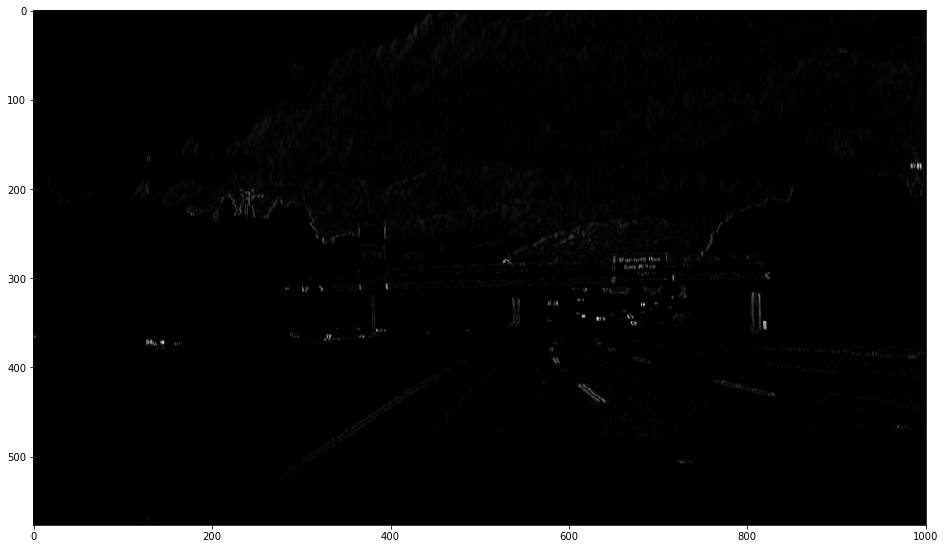

In [20]:
gray = cv2.cvtColor(t_img, cv2.COLOR_BGR2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
#abs_sobely = np.absolute(sobely)
#scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

#cmmn = np.zeros_like(scaled_sobely)
#cmmn[(scaled_sobely == 0) | (scaled_sobelx == 1)] = 1
plt.figure(figsize=(16,10))
plt.imshow(scaled_sobelx, cmap='gray')
plt.show()

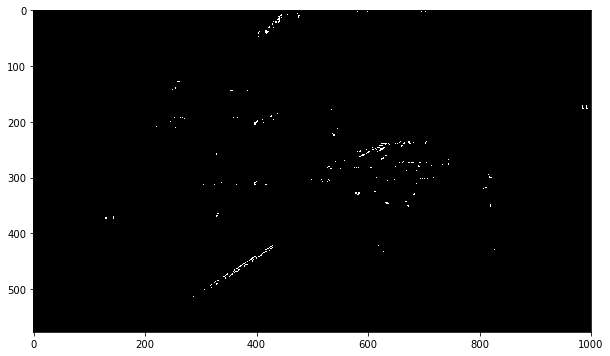

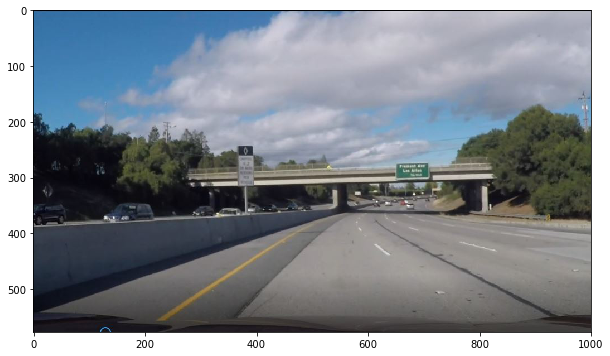

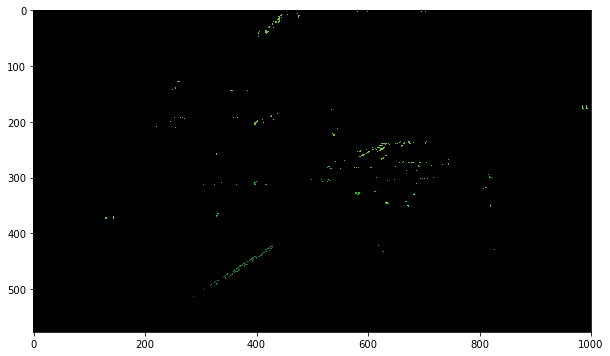

In [21]:
thresh_min = 10
thresh_max = 255
sybinary = np.zeros_like(scaled_sobely)
sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1
sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
binary = (sxbinary + sybinary)//2
#plt.imshow(binary, cmap='gray')
#plt.show()

#sobelxy = np.sqrt(sobelx**2 + sobely**2)
#scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
#thresh_min = 20
#thresh_max = 200
#sxybinary = np.zeros_like(scaled_sobel)
#sxybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
#plt.imshow(sxybinary, cmap='gray')
#plt.show()

#sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
#sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
# Take the absolute value of the x and y gradients
#abs_sobelx = np.absolute(sobelx)
#abs_sobely = np.absolute(sobely)
#sobel_thresh = np.arctan2(abs_sobely, abs_sobelx)
#thresh_min = 0.9
#thresh_max = 1.3
#abinary = np.zeros_like(sobelx)
#abinary[(sobel_thresh >= thresh_min) & (sobel_thresh <= thresh_max)] = 1
#plt.imshow(abinary, cmap='gray')
#plt.show()

nbin = np.zeros_like(sobelx)
nbin[(binary == 1) & (obinary == 1)] = 1
plt.figure(figsize=(10,6))
plt.imshow(nbin, cmap='gray')
plt.show()

#### soften this image ####
kernel_size = 5
blur_image = gaussian_blur(nbin, kernel_size)
#plt.figure(figsize=(10,6))
#plt.imshow(blur_image, cmap='gray')
#plt.show()

plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.show()
cp_img = np.copy(img_hls)
cp_img[nbin != 1] = [0, 0, 0]
plt.figure(figsize=(10,6))
plt.imshow(cp_img)
plt.show()
#cp_img = cp_img[500:600, 250:450,:]
#plt.imshow(cp_img)
#plt.show()
#yl = cp_img[99,125]
#print(yl, abs(yl[0]-yl[1]), abs(yl[0]-yl[2]))
#yl = cp_img[97,62]
#print(yl, abs(yl[0]-yl[1]), abs(-yl[0]+yl[2]))

(1001, 577)


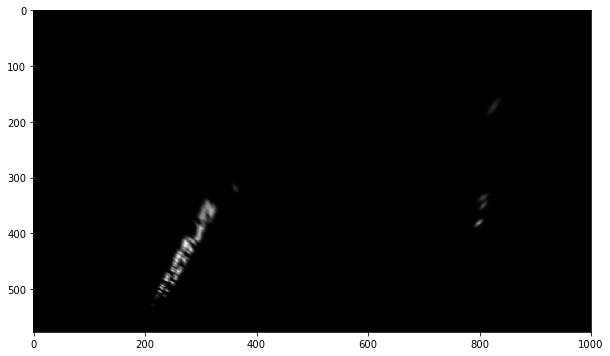

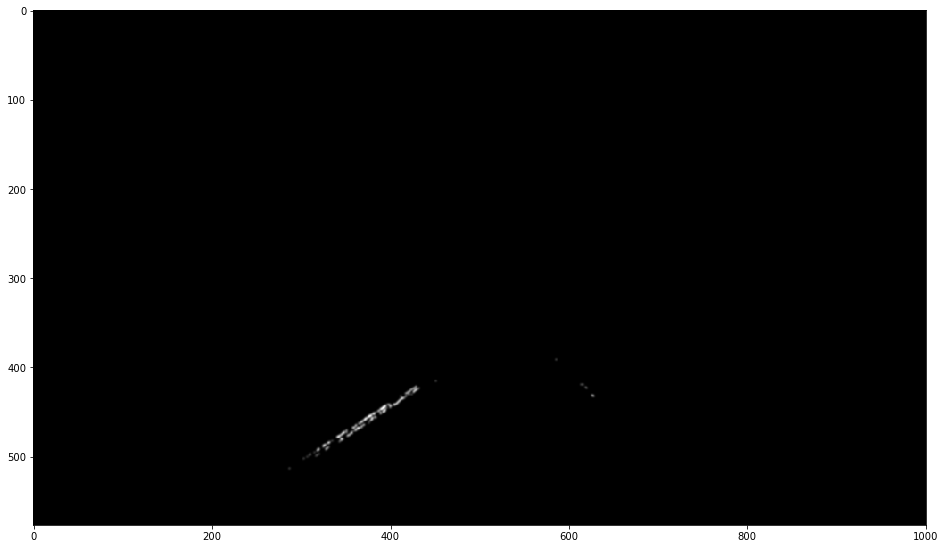

In [22]:

img_size = (blur_image.shape[1], blur_image.shape[0])
print(img_size)
# define 4 source points src = np.float32([[,],[,],[,],[,]])    
src = np.float32(([(img_size[0]/2)-100, img_size[1]*0.65],
    [(img_size[0]/2)+100, img_size[1]*0.65],
    [img_size[0], img_size[1]],
    [0, img_size[1]]))

# define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[0, 0],
    [img_size[0], 0],
    [img_size[0], img_size[1]],
    [0, img_size[1]]])
# use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# use cv2.warpPerspective() to warp your image to a top-down view
warped = cv2.warpPerspective(blur_image, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(warped, cmap="gray")
plt.show()

rM = cv2.getPerspectiveTransform(dst, src)
unwarped = cv2.warpPerspective(warped, rM, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(16,10))
plt.imshow(unwarped, cmap="gray")
plt.show()

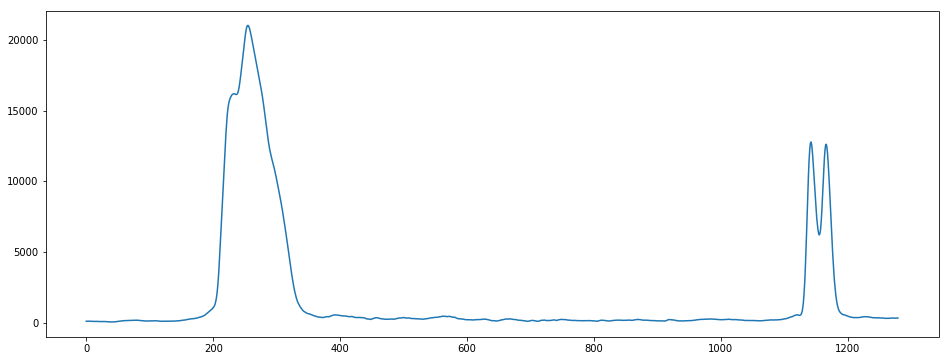

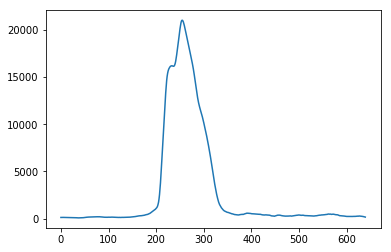

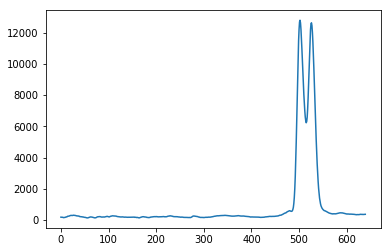

255 1142


In [36]:

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.figure(figsize=(16,6))
plt.plot(histogram)
plt.show()
left_hist = histogram[:len(histogram)//2]
right_hist = histogram[len(histogram)//2:]
plt.plot(left_hist)
plt.show()
plt.plot(right_hist)
plt.show()
sl = np.argmax(left_hist)
sr = np.argmax(right_hist) + len(histogram)//2
print(sl, sr)

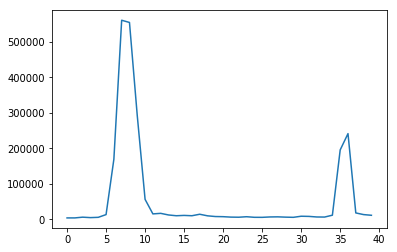

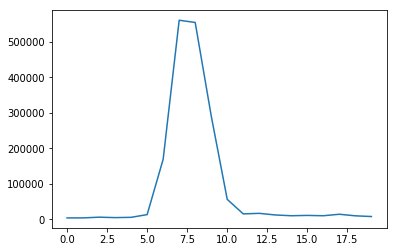

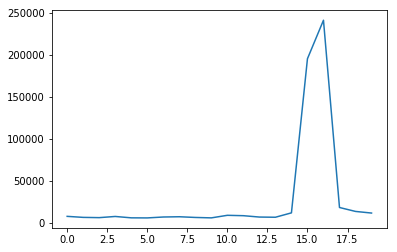

240 1168


In [37]:
# Effect of noise is visible quite much in the histogram
# To reduce this effect, instead of checking the peak of full array, take sum of pairs of n adjacent pixels
new_histogram = []
histogram = list(histogram)
n = len(histogram)//40
# pad zeros to make width a multiple of 4
while int(len(histogram)%n) != 0:
    histogram.append(0)
for i in range(0, len(histogram), n):
    new_histogram.append(sum(histogram[i:i+n]))

plt.plot(new_histogram)
plt.show()

left_hist = new_histogram[:len(new_histogram)//2]
right_hist = new_histogram[len(new_histogram)//2:]
plt.plot(left_hist)
plt.show()
plt.plot(right_hist)
plt.show()

sl = np.argmax(left_hist)
sr = np.argmax(right_hist) + len(new_histogram)//2
print(sl*n + n//2, sr*n + n//2)

In [40]:
# This time output is similar but peaks are clearly visible

# find single base point
def find_base_top(histogram, group_size = 10):
    new_histogram = []
    histogram = list(histogram)
    while int(len(histogram)%group_size) != 0:
        histogram.append(0)
    for i in range(0, len(histogram), group_size):
        new_histogram.append(sum(histogram[i:i+group_size]))
    ct = np.argmax(new_histogram)
    base, top = 0, 0
    # loop backwards to get the base by finding the local minima
    # loop forward to get the top by finding the local minima
    for sv, lv, inc in [(ct, 0, -1), (ct, len(new_histogram), 1)]:
        dif = 0
        for i in range(sv, lv, inc):
            cdif = new_histogram[ct] - new_histogram[i]
            if cdif >= dif:
                dif = cdif
            else:
                if inc < 0:
                    base = i
                else:
                    top = i
                break
    base = int(round(base*group_size + group_size*0.65))  # This could be improved to increase accuracy
    top = int(round(top*group_size + group_size*0.45))
    return base, top

# create the function to find these values
def find_initial_base_top(histogram, group_size = 10):
    new_histogram = list(histogram)
    left_hist = new_histogram[:len(new_histogram)//2]
    right_hist = new_histogram[len(new_histogram)//2:]
    n = len(left_hist)
    bl, tl = find_base_top(left_hist, group_size)
    br, tr = find_base_top(right_hist, group_size)
    br, tr = br+n, tr+n
    return (bl, tl), (br, tr)

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
sl, sr = find_initial_base_top(histogram)
print(sl, sr)

(116, 384) (1146, 1224)


In [11]:
# Got the starting points, now perform a sliding window search
# > Divide the image into 20 segments vertically
# > For each segment, plot the histogram for width of 100 pixels towards both sides from last point
# > Get the inclination of the line
# > get optimal size of window for sliding window search
# > search for max sum value in direction as per inclination
# > find the start and the end point of curve in the current window

win_n = 20    # number of vertical segments
win_h = warped.shape[0] // win_n    # height of each segment
#print(win_h, win_h*win_n)
left_points = []   # [(x1, y1), (x2, y2), ...] points for left lane line
right_points = []  # points depicting right lane line
# points found for last window
tx_l, ty_l, tx_r, ty_r = 0, 0, 0, 0  # top
bx_l, by_l, bx_r, by_r = 0, 0, 0, 0  # bottom

cwin = np.sum(warped[warped.shape[0] - win_h:,:], axis=0)
tx, ty find_initial_base_top(cwin)
    
for cwin_n in range(1, win_n):
    win_min_y = warped.shape[0]*(win_n - cwin_n - 1)//win_n
    win_max_y = win_min_y + win_h
    if win_min_y < 0:
        win_min_y = 0
    print(win_max_y, win_min_y)
    cwin = np.sum(warped[win_min_y:win_max_y+1,:], axis=0)
    

SyntaxError: invalid syntax (<ipython-input-11-f805a992f7bd>, line 19)